In [ ]:
#Descargar dataset: https://www.kaggle.com/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - loss: 0.6920 - val_loss: 0.6879
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - loss: 0.6844 - val_loss: 0.6728
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.6628 - val_loss: 0.6328
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - loss: 0.6236 - val_loss: 0.6350
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.6188 - val_loss: 0.6166
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.6115 - val_loss: 0.6069
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.6017 - val_loss: 0.6026
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - loss: 0.6022 - val_loss: 0.6036
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - loss: 0.5981 - val_loss: 0.5984
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step - loss: 0.5942 - val_loss: 0.5974
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.5914 - val_loss: 0.5958
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.5893 - val_lo

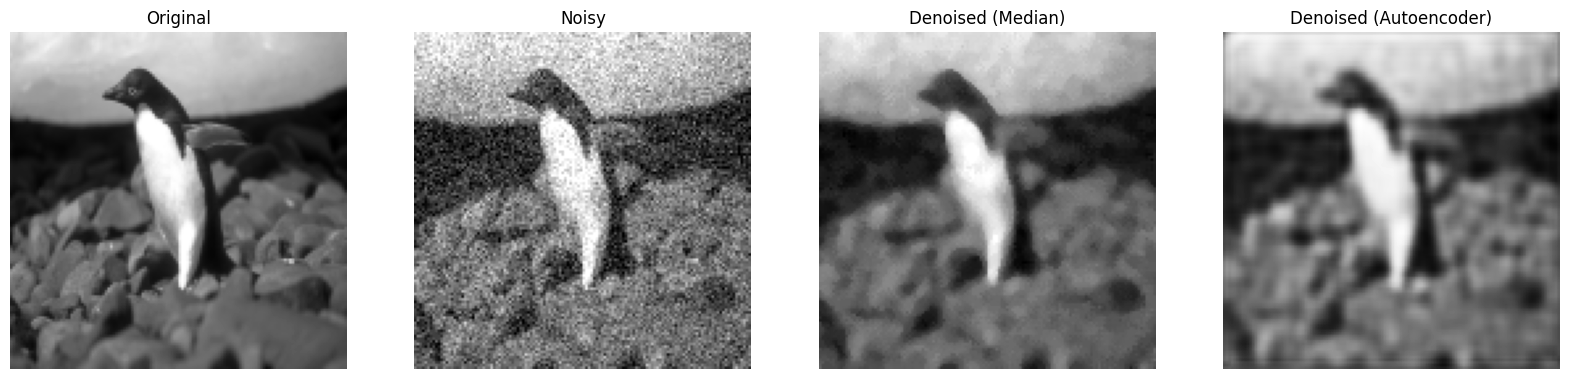

In [9]:
import os
import numpy as np
from skimage import io, color, util
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage.filters import median
from skimage.morphology import disk

def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    noisy_images = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                image = io.imread(image_path)
                if image is None:
                    continue
                if len(image.shape) == 3:
                    image = color.rgb2gray(image)
                image = util.img_as_float(image)
                image = resize(image, image_size, anti_aliasing=True)
                
                #noisy_image = util.random_noise(image, mode='gaussian', var=0.01)
                noisy_image = util.random_noise(image, mode='poisson')
                #noisy_image = util.random_noise(image, mode='s&p', amount=0.05)
                #noisy_image = util.random_noise(image, mode='speckle', var=0.01)

                images.append(image)
                noisy_images.append(noisy_image)
    
    images = np.array(images, dtype=np.float32)
    noisy_images = np.array(noisy_images, dtype=np.float32)

    images = np.expand_dims(images, axis=-1)
    noisy_images = np.expand_dims(noisy_images, axis=-1)

    return images, noisy_images

dataset_path = 'BSDS500/images/train'
images, noisy_images = load_and_preprocess_images(dataset_path)

x_train, x_val, y_train, y_val = train_test_split(noisy_images, images, test_size=0.3, random_state=42)

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

input_shape = (128, 128, 1)
autoencoder = build_autoencoder(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_autoencoder.keras', save_best_only=True, monitor='val_loss')

history = autoencoder.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

autoencoder.save('autoencoder_model.keras')

def apply_median_filter(image_path, image_size=(128, 128)):
    image = io.imread(image_path)
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    image = util.img_as_float(image)
    image = resize(image, image_size, anti_aliasing=True)
    noisy_image = util.random_noise(image, mode='gaussian', var=0.01)
    denoised_image = median(noisy_image, disk(3))
    return image, noisy_image, denoised_image

def apply_autoencoder(image_path, autoencoder, image_size=(128, 128)):
    image = io.imread(image_path)
    if len(image.shape) == 3:
        image = color.rgb2gray(image)
    image = util.img_as_float(image)
    image = resize(image, image_size, anti_aliasing=True)
    noisy_image = util.random_noise(image, mode='gaussian', var=0.01)
    noisy_image = np.expand_dims(noisy_image, axis=-1)
    noisy_image = np.expand_dims(noisy_image, axis=0)
    denoised_image = autoencoder.predict(noisy_image)
    noisy_image = np.squeeze(noisy_image)
    denoised_image = np.squeeze(denoised_image)
    return image, noisy_image, denoised_image

def evaluate_models(original, noisy, denoised_median, denoised_autoencoder):
    data_range = original.max() - original.min()
    
    psnr_noisy = peak_signal_noise_ratio(original, noisy, data_range=data_range)
    psnr_median = peak_signal_noise_ratio(original, denoised_median, data_range=data_range)
    psnr_autoencoder = peak_signal_noise_ratio(original, denoised_autoencoder, data_range=data_range)

    ssim_noisy = structural_similarity(original, noisy, data_range=data_range)
    ssim_median = structural_similarity(original, denoised_median, data_range=data_range)
    ssim_autoencoder = structural_similarity(original, denoised_autoencoder, data_range=data_range)

    results = {
        "PSNR Noisy": psnr_noisy,
        "PSNR Median": psnr_median,
        "PSNR Autoencoder": psnr_autoencoder,
        "SSIM Noisy": ssim_noisy,
        "SSIM Median": ssim_median,
        "SSIM Autoencoder": ssim_autoencoder
    }
    
    return results

def show_comparison(original, noisy, denoised_median, denoised_autoencoder):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original')
    axes[1].imshow(noisy, cmap='gray')
    axes[1].set_title('Noisy')
    axes[2].imshow(denoised_median, cmap='gray')
    axes[2].set_title('Denoised (Median)')
    axes[3].imshow(denoised_autoencoder, cmap='gray')
    axes[3].set_title('Denoised (Autoencoder)')
    for ax in axes:
        ax.axis('off')
    plt.show()

# Example usage:
image_path = 'BSDS500/images/test/106005.jpg'
original_image, noisy_image, denoised_image_median = apply_median_filter(image_path)
_, _, denoised_image_autoencoder = apply_autoencoder(image_path, autoencoder)

results = evaluate_models(original_image, noisy_image, denoised_image_median, denoised_image_autoencoder)
for key, value in results.items():
    print(f"{key}: {value:.2f}")

show_comparison(original_image, noisy_image, denoised_image_median, denoised_image_autoencoder)


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 238ms/step - loss: 0.6929 - val_loss: 0.6839
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.6790 - val_loss: 0.6677
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.6610 - val_loss: 0.6408
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - loss: 0.6344 - val_loss: 0.6161
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.6134 - val_loss: 0.6069
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.6008 - val_loss: 0.5960
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.5911 - val_loss: 0.5887
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.5865 - val_loss: 0.5863
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.5878 - val_loss: 0.5839
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - loss: 0.5771 - val_loss: 0.5804
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.5716 - val_loss: 0.5792
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - loss: 0.5714 - val_lo

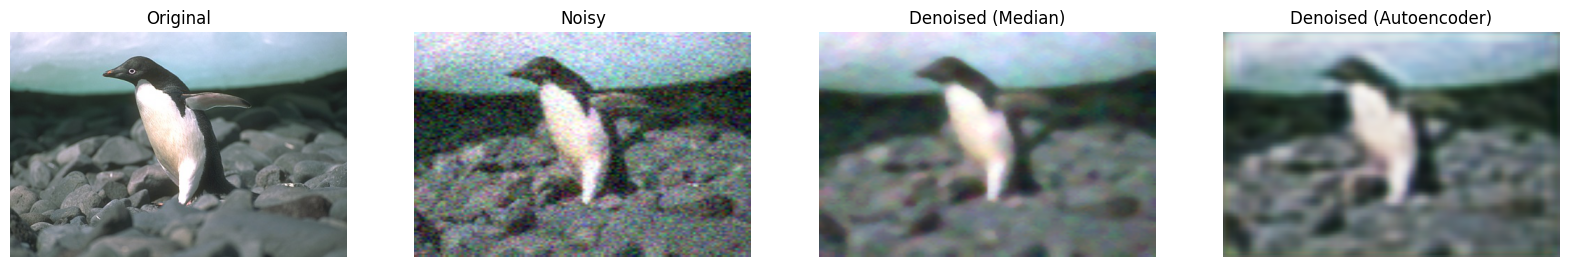

In [10]:
import os
import numpy as np
from skimage import io, util
from skimage.transform import resize
from skimage.filters import median
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    noisy_images = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                image = io.imread(image_path)
                image = util.img_as_float(image)
                image = resize(image, image_size, anti_aliasing=True)

                noisy_image = util.random_noise(image, mode='poisson')

                images.append(image)
                noisy_images.append(noisy_image)
    
    images = np.array(images, dtype=np.float32)
    noisy_images = np.array(noisy_images, dtype=np.float32)

    return images, noisy_images

dataset_path = 'BSDS500/images/train'
images, noisy_images = load_and_preprocess_images(dataset_path)

x_train, x_val, y_train, y_val = train_test_split(noisy_images, images, test_size=0.3, random_state=42)

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

input_shape = (128, 128, 3)
autoencoder = build_autoencoder(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_autoencoder.keras', save_best_only=True, monitor='val_loss')

history = autoencoder.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

autoencoder.save('autoencoder_model.keras')

def apply_median_filter(image_path, image_size=(128, 128)):
    image = io.imread(image_path)
    image = util.img_as_float(image)
    original_shape = image.shape
    image_resized = resize(image, image_size, anti_aliasing=True)
    noisy_image = util.random_noise(image_resized, mode='gaussian', var=0.01)
    denoised_image = np.zeros_like(noisy_image)
    for i in range(3):
        denoised_image[:, :, i] = median(noisy_image[:, :, i], disk(3))
    denoised_image = resize(denoised_image, original_shape, anti_aliasing=True)
    noisy_image = resize(noisy_image, original_shape, anti_aliasing=True)
    return image, noisy_image, denoised_image

def apply_autoencoder(image_path, autoencoder, image_size=(128, 128)):
    image = io.imread(image_path)
    image = util.img_as_float(image)
    original_shape = image.shape
    image_resized = resize(image, image_size, anti_aliasing=True)
    noisy_image = util.random_noise(image_resized, mode='gaussian', var=0.01)
    noisy_image = np.expand_dims(noisy_image, axis=0)
    denoised_image = autoencoder.predict(noisy_image)
    noisy_image = np.squeeze(noisy_image)
    denoised_image = np.squeeze(denoised_image)
    denoised_image = resize(denoised_image, original_shape, anti_aliasing=True)
    noisy_image = resize(noisy_image, original_shape, anti_aliasing=True)
    return image, noisy_image, denoised_image

def evaluate_models(original, noisy, denoised_median, denoised_autoencoder):
    psnr_noisy = peak_signal_noise_ratio(original, noisy, data_range=original.max() - original.min())
    psnr_median = peak_signal_noise_ratio(original, denoised_median, data_range=original.max() - original.min())
    psnr_autoencoder = peak_signal_noise_ratio(original, denoised_autoencoder, data_range=original.max() - original.min())

    min_dim = min(original.shape[0], original.shape[1])
    win_size = min(7, min_dim)
    if win_size % 2 == 0:
        win_size -= 1  # Asegurar que el win_size es impar

    ssim_noisy = structural_similarity(original, noisy, multichannel=True, data_range=original.max() - original.min(), win_size=win_size, channel_axis=-1)
    ssim_median = structural_similarity(original, denoised_median, multichannel=True, data_range=original.max() - original.min(), win_size=win_size, channel_axis=-1)
    ssim_autoencoder = structural_similarity(original, denoised_autoencoder, multichannel=True, data_range=original.max() - original.min(), win_size=win_size, channel_axis=-1)

    print(f"PSNR Noisy: {psnr_noisy:.2f}")
    print(f"PSNR Median: {psnr_median:.2f}")
    print(f"PSNR Autoencoder: {psnr_autoencoder:.2f}")

    print(f"SSIM Noisy: {ssim_noisy:.4f}")
    print(f"SSIM Median: {ssim_median:.4f}")
    print(f"SSIM Autoencoder: {ssim_autoencoder:.4f}")

def show_comparison(original, noisy, denoised_median, denoised_autoencoder):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[1].imshow(noisy)
    axes[1].set_title('Noisy')
    axes[2].imshow(denoised_median)
    axes[2].set_title('Denoised (Median)')
    axes[3].imshow(denoised_autoencoder)
    axes[3].set_title('Denoised (Autoencoder)')
    for ax in axes:
        ax.axis('off')
    plt.show()

# Ejemplo de uso:
image_path = 'BSDS500/images/test/106005.jpg'
original_image, noisy_image, denoised_image_median = apply_median_filter(image_path)
_, _, denoised_image_autoencoder = apply_autoencoder(image_path, autoencoder)

evaluate_models(original_image, noisy_image, denoised_image_median, denoised_image_autoencoder)
show_comparison(original_image, noisy_image, denoised_image_median, denoised_image_autoencoder)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 0.0624 - val_loss: 0.0600
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 879ms/step - loss: 0.0542 - val_loss: 0.0543
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 948ms/step - loss: 0.0470 - val_loss: 0.0418
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 904ms/step - loss: 0.0373 - val_loss: 0.0393
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 906ms/step - loss: 0.0357 - val_loss: 0.0384
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0328 - val_loss: 0.0342
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0300 - val_loss: 0.0330
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 953ms/step - loss: 0.0296 - val_loss: 0.0365
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0296 - val_loss: 0.0296
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 956ms/step - loss: 0.0262 - val_loss: 0.0264
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0233 - val_loss: 0.0211
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 889ms/step - loss: 0.0201 - val_loss:

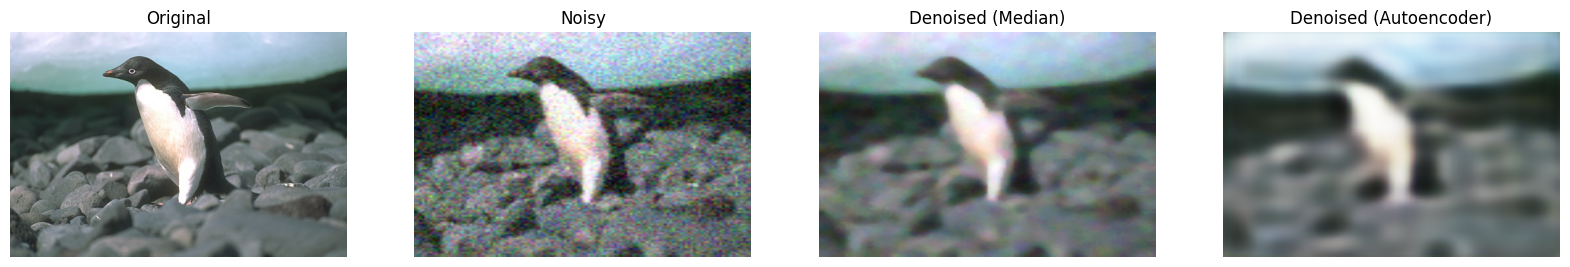

In [17]:
import os
import numpy as np
from skimage import io, util
from skimage.transform import resize
from skimage.filters import median
from skimage.morphology import disk
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_and_preprocess_images(dataset_path, image_size=(128, 128)):
    images = []
    noisy_images = []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                image = io.imread(image_path)
                image = util.img_as_float(image)
                image = resize(image, image_size, anti_aliasing=True)

                noisy_image = util.random_noise(image, mode='gaussian', var=0.01)

                images.append(image)
                noisy_images.append(noisy_image)
    
    images = np.array(images, dtype=np.float32)
    noisy_images = np.array(noisy_images, dtype=np.float32)

    return images, noisy_images

dataset_path = 'BSDS500/images/train'
images, noisy_images = load_and_preprocess_images(dataset_path)

x_train, x_val, y_train, y_val = train_test_split(noisy_images, images, test_size=0.20, random_state=42)

def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

input_shape = (128, 128, 3)
autoencoder = build_autoencoder(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_autoencoder.keras', save_best_only=True, monitor='val_loss')

history = autoencoder.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    shuffle=True,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

autoencoder.save('autoencoder_model.keras')

def apply_median_filter(image_path, image_size=(128, 128)):
    image = io.imread(image_path)
    image = util.img_as_float(image)
    original_shape = image.shape
    image_resized = resize(image, image_size, anti_aliasing=True)
    noisy_image = util.random_noise(image_resized, mode='gaussian', var=0.01)
    denoised_image = np.zeros_like(noisy_image)
    for i in range(3):
        denoised_image[:, :, i] = median(noisy_image[:, :, i], disk(3))
    denoised_image = resize(denoised_image, original_shape, anti_aliasing=True)
    noisy_image = resize(noisy_image, original_shape, anti_aliasing=True)
    return image, noisy_image, denoised_image

def apply_autoencoder(image_path, autoencoder, image_size=(128, 128)):
    image = io.imread(image_path)
    image = util.img_as_float(image)
    original_shape = image.shape
    image_resized = resize(image, image_size, anti_aliasing=True)
    noisy_image = util.random_noise(image_resized, mode='gaussian', var=0.01)
    noisy_image = np.expand_dims(noisy_image, axis=0)
    denoised_image = autoencoder.predict(noisy_image)
    noisy_image = np.squeeze(noisy_image)
    denoised_image = np.squeeze(denoised_image)
    denoised_image = resize(denoised_image, original_shape, anti_aliasing=True)
    noisy_image = resize(noisy_image, original_shape, anti_aliasing=True)
    return image, noisy_image, denoised_image

def evaluate_models(original, noisy, denoised_median, denoised_autoencoder):
    psnr_noisy = peak_signal_noise_ratio(original, noisy, data_range=original.max() - original.min())
    psnr_median = peak_signal_noise_ratio(original, denoised_median, data_range=original.max() - original.min())
    psnr_autoencoder = peak_signal_noise_ratio(original, denoised_autoencoder, data_range=original.max() - original.min())

    min_dim = min(original.shape[0], original.shape[1])
    win_size = min(7, min_dim)
    if win_size % 2 == 0:
        win_size -= 1  # Asegurar que el win_size es impar

    ssim_noisy = structural_similarity(original, noisy, channel_axis=-1, data_range=original.max() - original.min(), win_size=win_size)
    ssim_median = structural_similarity(original, denoised_median, channel_axis=-1, data_range=original.max() - original.min(), win_size=win_size)
    ssim_autoencoder = structural_similarity(original, denoised_autoencoder, channel_axis=-1, data_range=original.max() - original.min(), win_size=win_size)

    print(f"PSNR Noisy: {psnr_noisy:.2f}")
    print(f"PSNR Median: {psnr_median:.2f}")
    print(f"PSNR Autoencoder: {psnr_autoencoder:.2f}")

    print(f"SSIM Noisy: {ssim_noisy:.4f}")
    print(f"SSIM Median: {ssim_median:.4f}")
    print(f"SSIM Autoencoder: {ssim_autoencoder:.4f}")

def show_comparison(original, noisy, denoised_median, denoised_autoencoder):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[1].imshow(noisy)
    axes[1].set_title('Noisy')
    axes[2].imshow(denoised_median)
    axes[2].set_title('Denoised (Median)')
    axes[3].imshow(denoised_autoencoder)
    axes[3].set_title('Denoised (Autoencoder)')
    for ax in axes:
        ax.axis('off')
    plt.show()

# Example usage:
image_path = 'BSDS500/images/test/106005.jpg'
original_image, noisy_image, denoised_image_median = apply_median_filter(image_path)
_, _, denoised_image_autoencoder = apply_autoencoder(image_path, autoencoder)

evaluate_models(original_image, noisy_image, denoised_image_median, denoised_image_autoencoder)
show_comparison(original_image, noisy_image, denoised_image_median, denoised_image_autoencoder)


Total images loaded: 200
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.6873 - val_loss: 0.6333
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.6201 - val_loss: 0.6083
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.6000 - val_loss: 0.6010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.5882 - val_loss: 0.5965
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.5874 - val_loss: 0.5920
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.5826 - val_loss: 0.5967
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.5844 - val_loss: 0.5911
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.5749 - val_loss: 0.5870
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.5777 - val_loss: 0.5893
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.5816 - val_loss: 0.5851
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.5690 - val_loss: 0.5845
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━

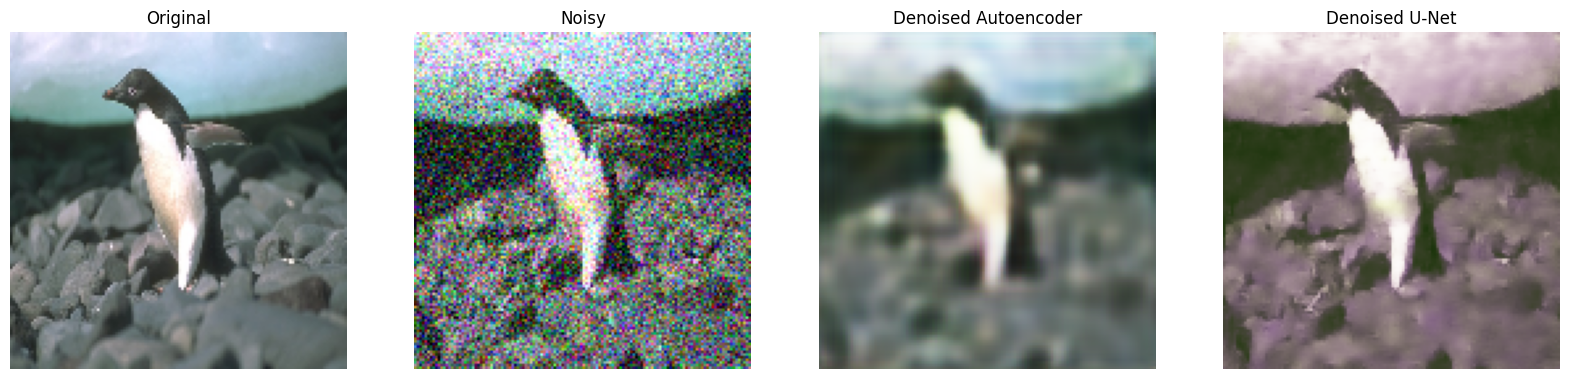

In [12]:
import os
import cv2
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# Función para cargar y preprocesar imágenes del dataset
def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, target_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.astype('float32') / 255
            images.append(img)
    return np.array(images)

# Ruta del dataset
train_folder = 'BSDS500/images/train'

# Cargar y preprocesar imágenes
target_size = (128, 128)
images = load_images_from_folder(train_folder, target_size=target_size)
print(f'Total images loaded: {images.shape[0]}')

# Generar ruido
noise_factor = 0.2
images_noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
images_noisy = np.clip(images_noisy, 0., 1.)

# Implementar Autoencoder mejorado
def build_autoencoder(input_shape=(128, 128, 3)):
    input_img = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder

# Implementar U-Net
def build_unet(input_size=(128, 128, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Crear y entrenar el modelo Autoencoder
autoencoder = build_autoencoder(input_shape=(128, 128, 3))
autoencoder.fit(images_noisy, images, epochs=50, batch_size=8, shuffle=True, validation_split=0.1)

# Evaluar el Autoencoder
denoised_images_autoencoder = autoencoder.predict(images_noisy)
original_image = images[0]
noisy_image = images_noisy[0]
denoised_image_autoencoder = denoised_images_autoencoder[0]
psnr_autoencoder = peak_signal_noise_ratio(original_image, denoised_image_autoencoder, data_range=original_image.max() - original_image.min())
ssim_autoencoder = structural_similarity(original_image, denoised_image_autoencoder, channel_axis=2, data_range=original_image.max() - original_image.min())
print(f'PSNR Autoencoder: {psnr_autoencoder}')
print(f'SSIM Autoencoder: {ssim_autoencoder}')

# Crear y entrenar el modelo U-Net
unet = build_unet(input_size=(128, 128, 3))
unet.fit(images_noisy, images, epochs=50, batch_size=8, shuffle=True, validation_split=0.1)

# Evaluar el U-Net
denoised_images_unet = unet.predict(images_noisy)
denoised_image_unet = denoised_images_unet[0]
psnr_unet = peak_signal_noise_ratio(original_image, denoised_image_unet, data_range=original_image.max() - original_image.min())
ssim_unet = structural_similarity(original_image, denoised_image_unet, channel_axis=2, data_range=original_image.max() - original_image.min())
print(f'PSNR U-Net: {psnr_unet}')
print(f'SSIM U-Net: {ssim_unet}')

##################################################################################################################################
# Ruta de la imagen de prueba
image_path = 'BSDS500/images/test/106005.jpg'

# Función para cargar y preprocesar una imagen individual
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32') / 255
    return img

# Cargar la imagen de prueba
test_image = load_and_preprocess_image(image_path, target_size=target_size)

# Añadir ruido a la imagen de prueba
test_image_noisy = test_image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_image.shape)
test_image_noisy = np.clip(test_image_noisy, 0., 1.)

# Restaurar la imagen con el Autoencoder
test_image_denoised_autoencoder = autoencoder.predict(np.expand_dims(test_image_noisy, axis=0))[0]

# Restaurar la imagen con el U-Net
test_image_denoised_unet = unet.predict(np.expand_dims(test_image_noisy, axis=0))[0]

# Mostrar las imágenes originales, ruidosas y restauradas
plt.figure(figsize=(20, 10))

plt.subplot(1, 4, 1)
plt.title('Original')
plt.imshow(test_image)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title('Noisy')
plt.imshow(test_image_noisy)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title('Denoised Autoencoder')
plt.imshow(test_image_denoised_autoencoder)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title('Denoised U-Net')
plt.imshow(test_image_denoised_unet)
plt.axis('off')

plt.show()